In [1]:
# %cd '/home/ubuntu/1.1Tdisk/vijay/TestingPackages'
# from ood import OOD

## do the other extra stuff

In [71]:
train_json = '/home/ubuntu/1.1Tdisk/vijay/walmart/dataset/training_valid_dataset/combined_data/train_data/images/images.json'
test_json = '/home/ubuntu/1.1Tdisk/vijay/walmart/dataset/training_valid_dataset/combined_data/val_data/images/images.json'

In [72]:
import json
with open(test_json, 'r') as f:
    test_data = json.load(f)
with open(train_json, 'r') as f:
    train_data = json.load(f)

test_embeddings = [d['embedding'] for d in test_data]
test_filepaths = [d['filepath'] for d in test_data]
train_embeddings = [d['embedding'] for d in train_data]
train_filepaths = [d['filepath'] for d in train_data]

In [4]:
from umap import UMAP
import plotly.express as px

embeddings = [d for d in train_embeddings] + [d for d in test_embeddings]
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42)
umap_data_2d = umap_model.fit_transform(embeddings)

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [6]:
%cd '/home/ubuntu/1.1Tdisk/vijay/TestingPackages'
from clustering import Clustering

/home/ubuntu/1.1Tdisk/vijay/TestingPackages


In [11]:
model_train = Clustering(train_json)
model_test = Clustering(test_json)

No of Images:  623


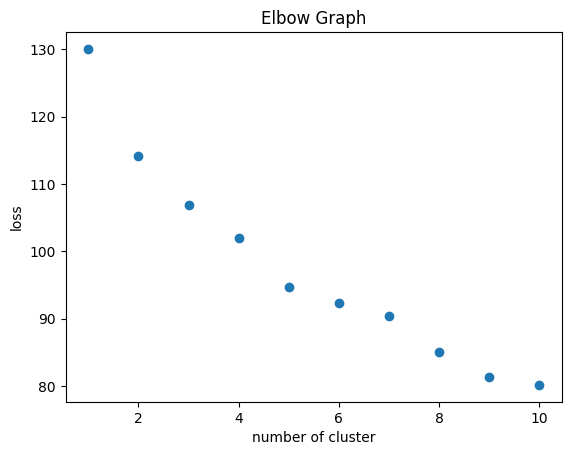

In [12]:
model_train.plot_elbow(k_range=(1, 10))

In [22]:
model_train.plot_umap(n_clusters=2)

No of Images:  196


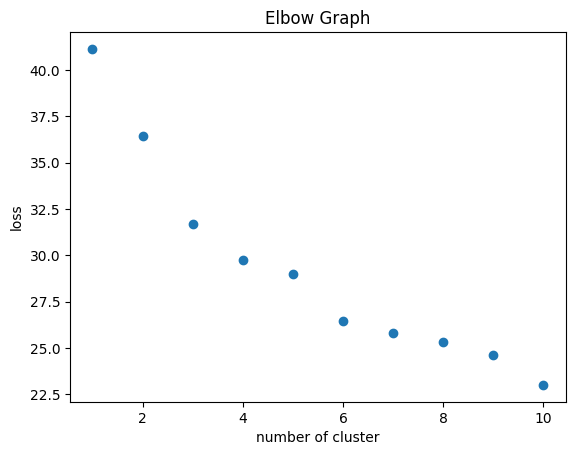

In [13]:
model_test.plot_elbow(k_range=(1, 10))

In [18]:
model_test.plot_umap(n_clusters=6)

In [29]:
train_map = {'0': 'train_0', '1': 'train_1', '2': 'train_2', '3': 'train_3', '4': 'train_4', '5': 'train_5'}
test_map = {'0': 'test_0', '1': 'test_1', '2': 'test_2', '3': 'test_3', '4': 'test_4', '5': 'test_5'}

In [30]:
train_label = [train_map[str(i)] for i in model_train.return_labels(n_clusters=5)]
test_label = [test_map[str(i)] for i in model_test.return_labels(n_clusters=6)]

In [31]:
labels = train_label + test_label
fig = px.scatter(umap_data_2d, x=0, y=1, color=labels, labels={"color": "drift"})
fig.show()

## do the drift

In [33]:
from DriftDetection import DriftDetector

In [68]:
import numpy as np

n_train = 5
train_labels = model_train.return_labels(n_clusters=n_train).tolist()

n_test = 6
test_labels = model_test.return_labels(n_clusters=n_test).tolist()

metrics = [
            "euclidean_distance",
            "cosine_distance",
            "maximum_mean_discrepancy",
            "population_stability_index",
            "ks_test",
            "partial_wasserstein_distance",
        ]

drifts = [[0 for i in range(n_test)] for j in range(n_train)]
for reference in range(n_train):
    reference_emb = []
    for e, l in zip(train_embeddings, train_labels):
        if l == reference:
            reference_emb.append(e)
    reference_emb = np.array(reference_emb)
    detector = DriftDetector(reference_emb)
    detector.set_thresholds_for_all_metrics()
            
    for field in range(n_test):
        test_emb =[]
        for e, l in zip(test_embeddings, test_labels):
            if l == field:
                test_emb.append(e)
        test_emb =np.array(test_emb)
           
        results = []
        for metric in metrics:
            result = detector.is_drift(test_emb, metric)
            results.append(result['is_drift'])
                    
        # fieldnames = ['is_drift', 'distance_metric_value', 'threshold_value_used', 'metric_used']
        # df = pd.DataFrame(results, columns=fieldnames)
        # df.head()
        
        drifts[reference][field] = sum(results) == 6

In [69]:
for i in range(n_train):
    print(drifts[i])

[True, True, True, False, True, False]
[True, True, False, True, False, True]
[False, True, True, False, False, True]
[True, True, False, True, False, True]
[True, False, False, False, True, False]


In [54]:
import pandas as pd

# Data
data = [
    [True, True, True, False, True, False],
    [True, True, False, True, False, True],
    [False, True, True, False, False, True],
    [True, True, False, True, False, True],
    [True, False, False, False, True, False]
]

# Column labels
columns = [f"test_{i}" for i in range(6)]

# Row labels
index = [f"train_{i}" for i in range(5)]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)

# Display the table
df


,test_0,test_1,test_2,test_3,test_4,test_5
train_0,True,True,True,False,True,False
train_1,True,True,False,True,False,True
train_2,False,True,True,False,False,True
train_3,True,True,False,True,False,True
train_4,True,False,False,False,True,False


## do the ood

In [73]:
from ood import OOD

In [110]:
n_train = 5
train_labels = model_train.return_labels(n_clusters=n_train).tolist()

n_test = 6
test_labels = model_test.return_labels(n_clusters=n_test).tolist()

In [79]:
len(test_embeddings), len(test_labels), len(test_paths)

(196, 196, 0)

In [111]:
len(train_labels)

623

No of Images:  149


THRESHOLD: 12.116893691608078


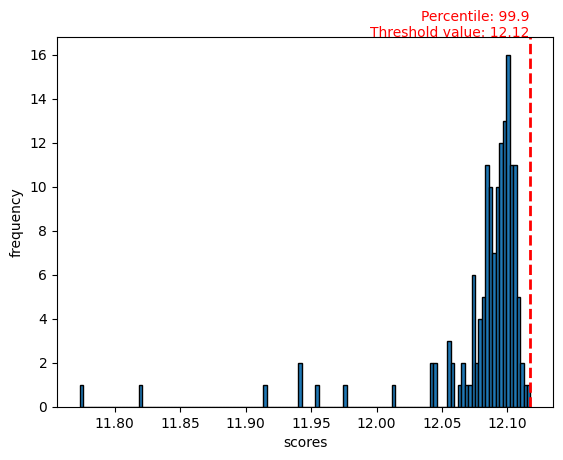

No of Images:  68
THRESHOLD: 8.123124783844778


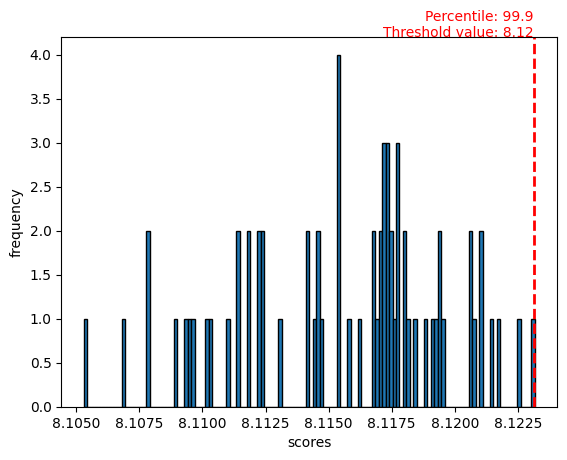

No of Images:  124
THRESHOLD: 11.037533923400842


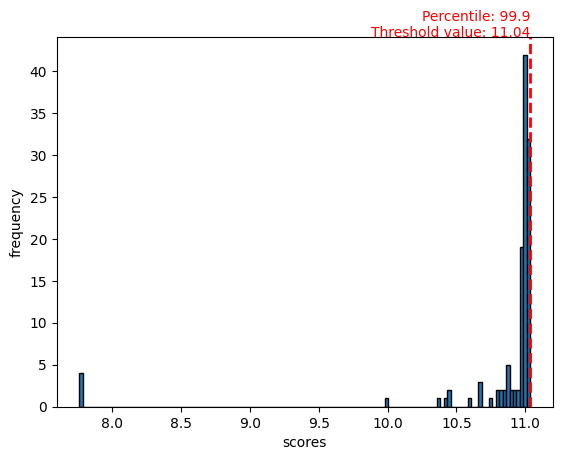

No of Images:  108
THRESHOLD: 10.291753697487609


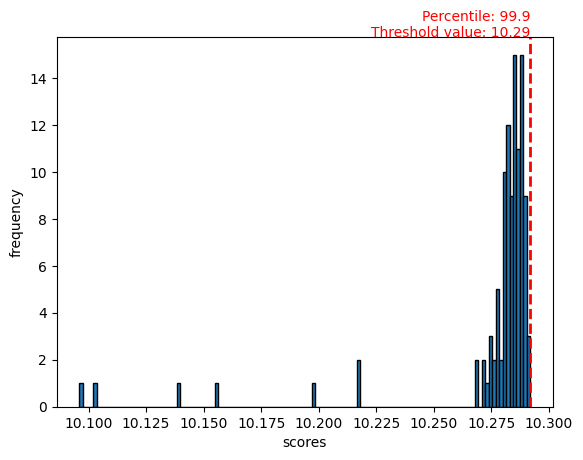

No of Images:  174
THRESHOLD: 13.097437868927026


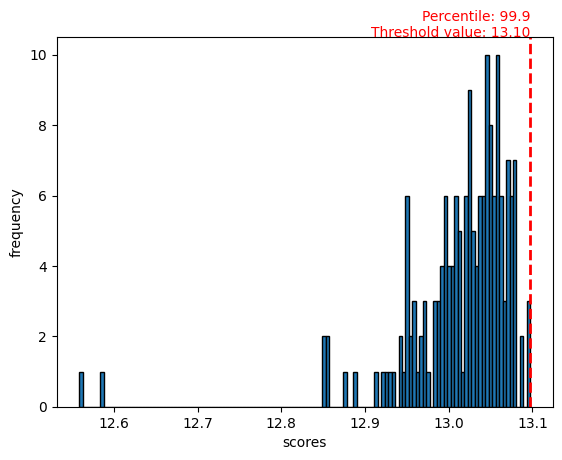

In [112]:
thres = []
ood_answer = [[0 for i in range(n_test)] for j in range(n_train)]
for reference in range(n_train):
    reference_emb = []
    reference_paths = []
    for i in range(len(train_embeddings)):
        l = train_labels[i]
        if l == reference:
            reference_emb.append(train_embeddings[i])
            reference_paths.append(train_filepaths[i])

    ood_model = OOD((reference_emb, reference_paths), flag=False)
    THRESHOLD = ood_model.plot_score_histogram(percentile=99.9)
    thres.append(THRESHOLD)
    THRESHOLD = 250
    # THRESHOLDs.append(THRESHOLD)
    # print(THRESHOLDs)

    for field in range(n_test):
        test_emb =[]
        for i in range(len(test_embeddings)):
            l = test_labels[i]
            if l == field:
                test_emb.append(test_embeddings[i])
        test_ood_scores = ood_model.calculate_ood_score(test_emb)  
        
        n_ood = sum([1 if s > THRESHOLD else 0 for s in test_ood_scores])    
        n_ind = sum([0 if s > THRESHOLD else 1 for s in test_ood_scores])
        # total = len(test_ood_scores)
        
        ood_answer[reference][field] = (n_ood, n_ind)
                
        # break
    # break


In [113]:
for i in range(n_train):
    print(ood_answer[i])

[(4, 6), (20, 3), (12, 25), (0, 32), (24, 15), (12, 43)]
[(2, 8), (5, 18), (37, 0), (32, 0), (39, 0), (55, 0)]
[(10, 0), (23, 0), (36, 1), (32, 0), (1, 38), (49, 6)]
[(10, 0), (23, 0), (11, 26), (31, 1), (38, 1), (32, 23)]
[(10, 0), (23, 0), (29, 8), (22, 10), (19, 20), (0, 55)]


In [107]:
#              test_0       test_1       test_2       test_3       test_4       test_5       
#               ood   ind    ood   ind    ood   ind    ood   ind    ood   ind    ood   ind   
# train                                                                                                     
# train_0       10     0     23     0     37     0     28     4     39     0     48     7  
# train_1       10     0     23     0     37     0     32     0     39     0     55     0   
# train_2       10     0     23     0     37     0     32     0     26    13     55     0   
# train_3       10     0     23     0     37     0     32     0     39     0     55     0    
# train_4       10     0     23     0     37     0     32     0     39     0     37    18  


